# Transformer Model
## - German to English Translation

## Problem that the Transformer Model Solves

Up till the Transformer model, the Seq2Seq was the most successful model for NLP tasks such as translations and summarization.

The problem however, is that each token is passed one at a time into the Seq2Seq model making the process extremely slow.

The Transformer Model takes advantage of the parallel processing power of the computer and takes all tokens of a sentence simultaneously as input.
This speeds things up!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy 
import numpy as np

import random
import math
import time

## Preprocessing

In [2]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                   fields = (SRC, TRG))

In [3]:
print(f'Number of training examples: {len(train_data.examples)}')
print(f'Number of validation examples: {len(valid_data.examples)}')
print(f'Number of test examples: {len(test_data.examples)}')
print()
print(vars(train_data.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of test examples: 1000

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [4]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

print(f"Unique tokens in source (de) vocab: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocab: {len(TRG.vocab)}")

Unique tokens in source (de) vocab: 7854
Unique tokens in target (en) vocab: 5893


In [5]:
device = ('cpu')
BATCH_SIZE = 128

#Creates batches, numericalizes data and splits data set into train, test and valid.
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
                                                    (train_data, valid_data, test_data),
                                                    batch_size = BATCH_SIZE,
                                                    device = device)



## Encoder

<img src="files/images/overview_encoder.png">

The Encoder receives the German tokens from the sentence.
It outputs context vectors to the Decoder.

In a normal Seq2Seq model, it outputs a single hidden vector to the Decoder.
The problem with this is that as the number of tokens in a sentence increases, the hidden vector loses info on the previous tokens, which can lead to suboptimal results at the end.
In a Transformer, each word is outputted as a context vector(Zt) so info regarding each token is retained. Each context vector also contains info of all other tokens in the sentence.

Steps:

1) Tokens of sentence get sent in simultaneously.

2) Tokens sent through a normal embedding layer and positional encoding layer.

3) The vector from both these layers are summed and passed into the Multi-Head Attention.

4) This summed vector is then multiplied by $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimmension size. (It apparently reduces the variance of the embedding layers and the scaling factor makes the model easier to train emperically.

4) The context vectors from the Multi-Head Attention layer are sent through a LayerNorm.

5) The output of this is sent through the Feedforward layer and another LayerNorm.

6) Finally, the output is sent to the Decoder.

<img src="files/images/overview_encoder2.png">

The output from the feedforward layer the gets send to the next Encoder layer.
The final Encoder layer then outputs the context vectors to the Decoder.

<img src="files/images/encoder_layers.png">


In [6]:
class Encoder(nn.Module):
    #input_dim = input sentence length
    #output_dim = output sentence length
    #n_layer = number of encoder layers we use (see image above)
    #n_heads = number of times the qkv matrices are divided (explained further under Multi-Headed Attention)
    #pf_dim = dimensions of the Positionwise Feedforward input
    #max_length = the max number of tokens per sentence that can be taken as input
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout,
                device, max_length = 100):
        #pf_dim = dimension of the feedfoward network (default is 2048).
        
        #max_length defines the max number of indices the Positional Encoder can provide to 
        #the numericalized tokens (or sentences).
        #E.g. "Sun is shining." - <sos>. 0, "Sun", 1.. (keep in mind the words are numericalized
        #so you won't see the actual word).
        super(Encoder, self).__init__()
        
        self.device = device
        
        #tok_embedding is a normal embedding layer that creates matrices to show a relationship
        #of one word to another.
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        
        #This embedding is done in the Positional Encoder before input is fed into Encoder.
        #Since Transformer does not take one input at a time (all input at once - parellization),
        #the Encoder will not know the order of the sentence, which can lead to construed meanings.
        #E.g. "dog ate cat" can be read as "ate dog cat" or "cat ate dog".
        #The Position Encoder will add the order of the input numericalized tokens.
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        #ModuleList creates an object similar to a list (can be indexed like a list) for Modules
        #and each Module stored in this list can be read by other Modules that inherit
        #the Module class. 
        #The input is passed through the n_layers number of Encoder layers.
        #It returns the value from the EncoderLayer class for n_layers amount of times into the
        #ModuleList object i.e. self.layers.
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim,
                                                 dropout, device)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        #The tok_embedding is multiplied by the square root of hid_dim as this has emprically 
        #shown to reduce variances in embeddings and makes the model easier to train.
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        #src_mask assigns a value of 1 to tokens that contain a word and 0 to tokens that contain
        #<pad>. This makes the process faster as <pad> input is ignored.
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #torch.arange() just returns a 1-D tensor.
        #torch.arange(start=0, end, step=1, out=None)
        #The size would be [(end-start)/step]
        #By default step = 1
        #So the tensor would contain ascending values like 0, 1, 2, 3, 4...
        #The unsqueeze adds an extra dimension.
        #From torch.size([3]) to --> torch.size([1, 3])
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]
        
        #The tok_embedding is first multiplied by the scale and summed w/ pos_embedding
        #before being passed into into the Encoder.
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src = [batch size, src len, hid dim]
        
        #This passes the input tokens to the different layers.
        for layer in self.layers:
            src = layer(src, src_mask)
        #src = [batch size, src len, hid dim]
        
        return src

In [7]:
#Showing how torch.arange() works.
a = torch.arange(0, 3, 1)
print("a = ", a)
print(a.size())
print()

a = torch.arange(0, 3, 1).unsqueeze(0)
print("a = ", a)
print(a.size())
print()

a = torch.arange(0, 3, 1).unsqueeze(0).repeat(10, 1)
print("a = ", a)
print(a.size())
print()

a =  tensor([0, 1, 2])
torch.Size([3])

a =  tensor([[0, 1, 2]])
torch.Size([1, 3])

a =  tensor([[0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2],
        [0, 1, 2]])
torch.Size([10, 3])



In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super(EncoderLayer, self).__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
        def forward(self, src, src_mask):
            #src = [batch size, src len, hid dim]
            #src_mask = [batch size, src len]
            
            #Self Attention Layer
            #????????? Why is src passed 3 times and then src_mask for device??
            _src, _ = self.self_attention(src, src, src, src_mask)
            
            #Dropout, Residual Connection and Normalization Layer
            src = self.self_attn_layer_norm(src + self.dropout(_src))
            
            #src = [batch size, src len, hid dim]
            
            #Positionwise feedforward
            _src = self.positionwise_feedforward(src)
            
            #Dropout, Residual Layer and Normalization Layer (of Feedforward Layer)
            src = self.ff_layer_norm(src + self.dropout(src))
            
            #src = [batch_size, src len, hid dim]
            
            return src

A new concept used by the Transformer is the Multi-Head Attention Layer (MHAL).

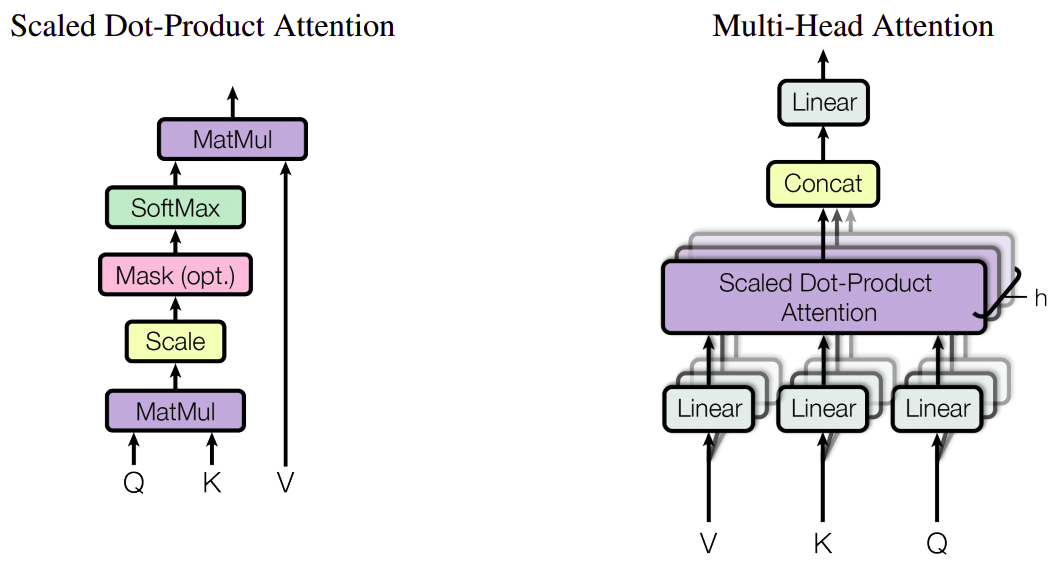

Keep in mind that all the words are fed in parellally to every layer in the Transformer. However, to understand the MHAL better, we will describing what happens when EACH word is passed into it.

E.g. "A cat climbed the tree."
First the Embedding matrix of "A" will be passed in.
Let's say X = Embedding vector of "A".

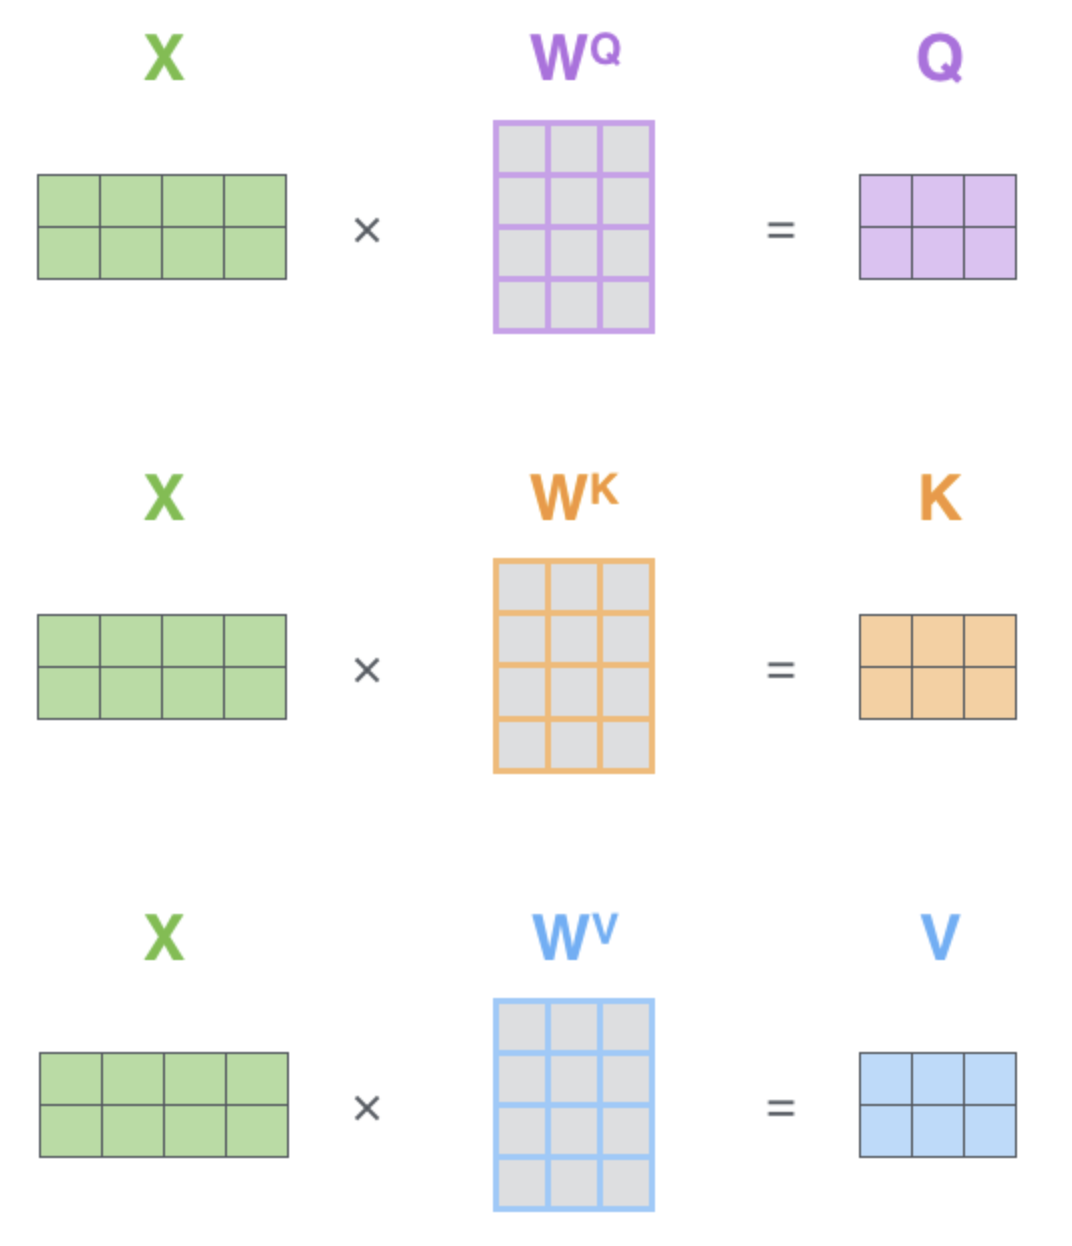


Initially, vectors V(value), K(key) and Q(Query) will be produced by splitting the Embedding matrix into smaller componants (doesn't necessarily have to be smaller).
They will then be passed through a Linear layer which will add weight to each vector.
This is repeated a total of 8 times in the Transformer paper.
---> [Wv0, Wk0, WQ0] then [Wv1, Wk1, WQ1] ..

The vectors are then passed through a Scaled Dot-Product Attention Layer where:
Query and Key are multiplied --> total is divided by the square root of the *number of head dimensions --> Softmax function is applied to this total and multiplied by the Value vector.
*Number of head dimensions = Hidden layer dimension (Embedding matrix) / number of heads
The Q, K and V vectors are split into 

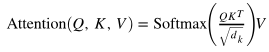

This is done 8 times according to the Transformer paper. Therefore each Head can be given as:
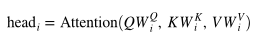

The heads are created because it makes the weights added to X to create the V, K and Q vectors more flexible. 
These vectors are randomly initialized at the start and after training it will be modified to minimize the loss.

To help better visualize what happens in the Scaled Dot-Product Attention:

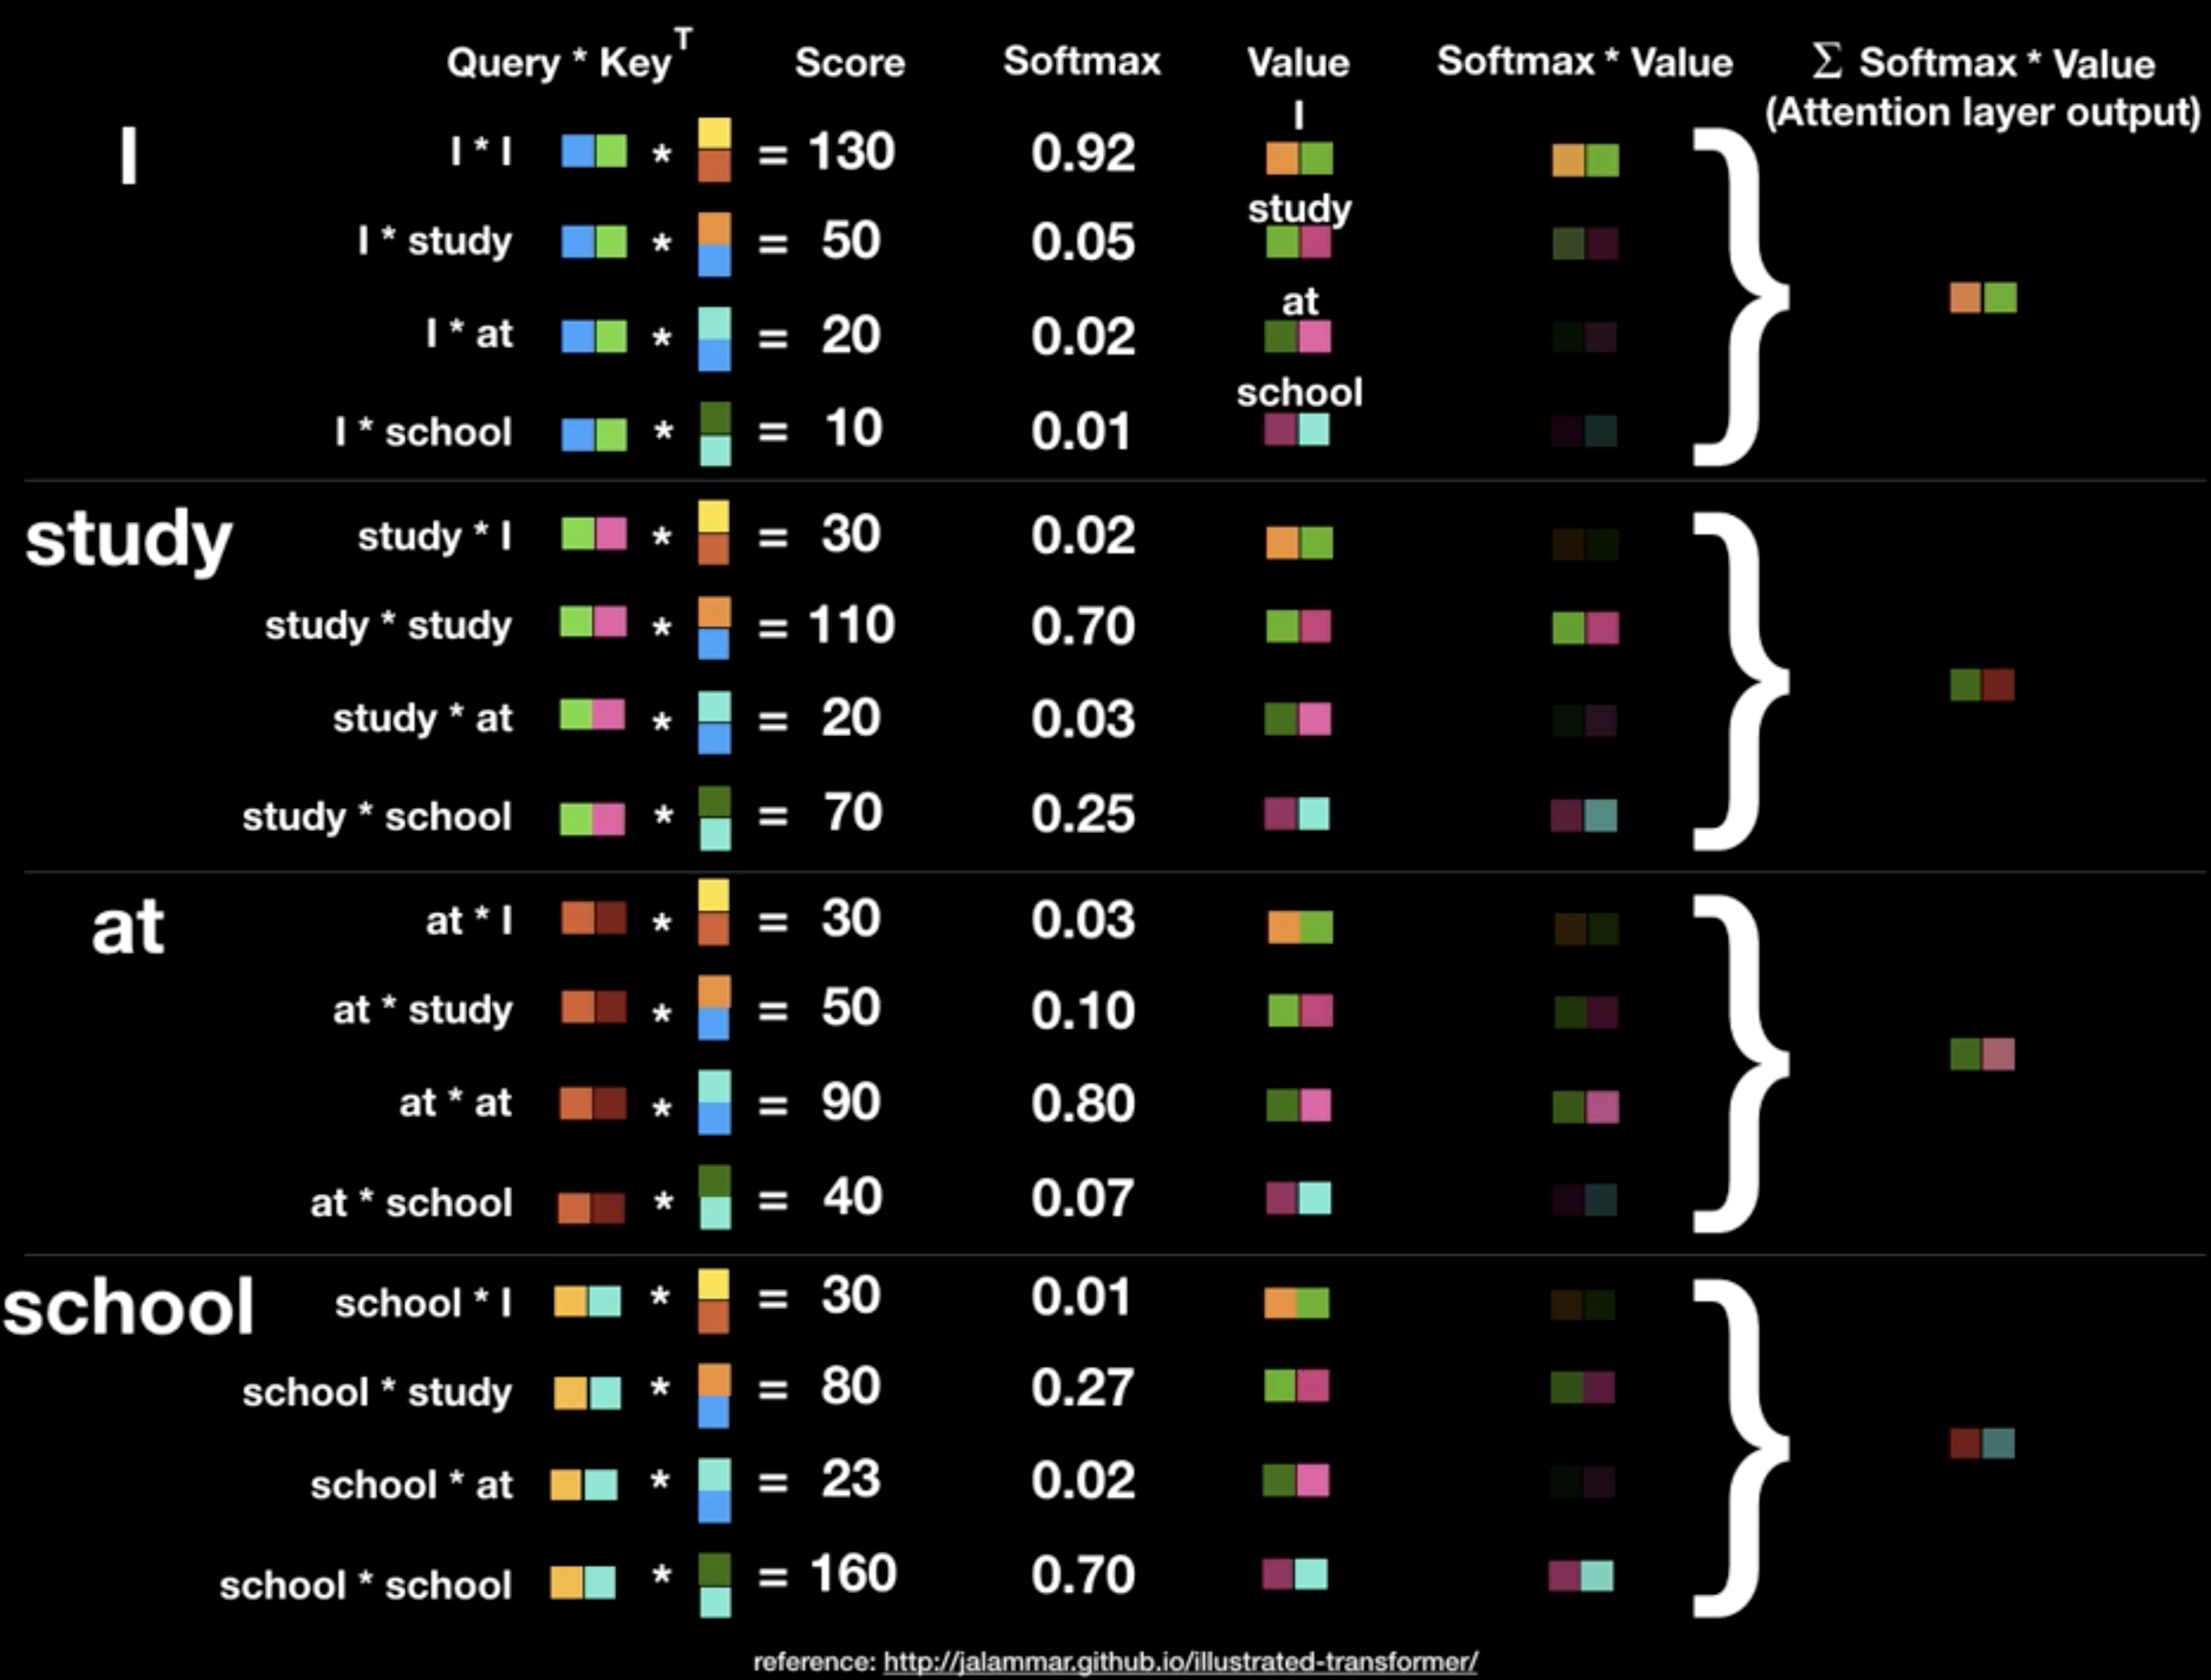

Keep in mind that the Q, K and V vectors have the same length making it easy to multiply them.
After the 8 Attention Vectors for each word are created, they are concatanated and multiplied with a weight (Wo) as only one Attention vector per word is passed to Feed Forward layer.

The Attention vector is passed through a Dropout layer, however the explanation for it is not given in the paper.




In [9]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super(MultiHeadAttentionLayer, self).__init__()
        
        #The hidden layer is split and therefore, can only contain whole numbers.
        #If the remainder is not 0, then Exception is called.
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        # Q - Query, K - Key, V - Value
        #Think of Query as in the current word that is being passed into the Decoder for translation.
        #In the given database, the model tries to find a matching Key.
        #The model returns a Value after it finds the matching Key. 
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        #Square roots the value.
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        Q = self.fc_q(self)
        K = self.fc_k(self)
        V = self.fc_v(self)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
        
        #.view() reshapes the Tensor.
        #The new shape will be a 4-D tensor with the shape -> [batch size, -1, n heads, head dim]
        #The -1 is for the method to decide what the value should be.
        #When reshaping, the new shape should be able to contain all the values in the original 
        #tensor.
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
        
        #permute() swaps the dimensions.
        #For explanation on contiguous() and permute() - 
        #https://jdhao.github.io/2019/07/10/pytorch_view_reshape_transpose_permute/
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch size, n heads, query len, key len]
        
        #Note that attention is passed through dropout layer before being multiplied with V.
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [10]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super(PositionwiseFeedforwardLayer, self).__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, seq len, hid dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x
    

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device,
                max_length = 100):
        super(Decoder, self).__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) 
                                    for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mark, src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        #trg = [batch size, trg len, hid dim]
        
        #After the input is sent through all the tok and pos embedding layers, we take the final
        #trg and attention output.
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
        
        return output, attention

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super(DecoderLayer, self).__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        # Masked Multi-Head Attention layer
        #Why do we use _trg and trg as two separate variables?
        #I personally think it is redundanct however, _trg variable is used to indicate the output 
        #of both the Multi-Head Attention and FFS layer. The trg variable is used to indicate
        #the output from the LayerNorm layers.
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        
        #Second Multi-Head Attention layer in the Decoder.
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [13]:
random = [1, 2, 1]
random = torch.tensor(random)
print(random.size())

print()
random3 = (random != 1).unsqueeze(1)

print(random3)

torch.Size([3])

tensor([[False],
        [ True],
        [False]])


In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        #The unsqueezing is to make sure the tensor has the correct dimensions when being applied
        #to the encoder output.
        #The (src != self.src_pad_idx) does the following:
        #If the value in the tensor is of the source pad value, then the tensor values is set to
        #False or in this case 0. Else it is set to True or in this case 1.
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) 
        
        #src_mask = [batch size, 1, 1, src len]
        
        return src_mask
    
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        
        #Check details on the src_mask implementation.
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
        
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask
    
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention


In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)

dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

In [16]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [17]:
def count_parameters(model):
    #numel() returns the total number of values in the tensor.
    #requires_grad is that the nodes are contributing to the caluclations in the model.
    #If it was set to False, then that part of the model will not be used for training.
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#numel() returns the total number of items in the input tensor. It is defined by PyTorch.
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,597 trainable parameters


In [18]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [19]:
model.apply(initialize_weights);

In [22]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optmizer.step()
        
        epoch_loss += loss.item()
        

In [52]:
random = np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8]])
print(random[:,:-1])
print(random[:,1:])
print(random.shape[0])

[[2 3 4]
 [6 7 8]]
2


In [60]:
x = torch.randn(3, 2)
y = torch.transpose(x, 0, 1)

print(x)
print()
print(y)

a = torch.range(1, 16)
print(a)
print(a.view(2, 8))

tensor([[-0.2959, -0.3660],
        [ 1.1878,  1.1319],
        [ 0.3885, -0.4298]])

tensor([[-0.2959,  1.1878,  0.3885],
        [-0.3660,  1.1319, -0.4298]])
tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16.])
tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12., 13., 14., 15., 16.]])


/Users/kavindasenewiratne/opt/anaconda3/envs/RNNTrial/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  


In [ ]:
Questions:
    1) What is the definition of dimensions in a feed forward network (parameter pf_dim).
    2) Not sure what nn.ModuleList is for.
    

In [ ]:
https://towardsdatascience.com/illustrated-guide-to-transformers-step-by-step-explanation-f74876522bc0
https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a
http://jalammar.github.io/illustrated-transformer/
https://www.youtube.com/watch?v=TQQlZhbC5ps&t=67s
https://www.youtube.com/watch?v=z1xs9jdZnuY
https://arxiv.org/pdf/1706.03762.pdf
https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb
https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
https://arxiv.org/pdf/1607.06450.pdf
        